In [1]:
import pyspark
print("PySpark:", pyspark.__version__)

PySpark: 3.5.1


In [2]:
import os, json, time
from pathlib import Path
from collections import deque
from typing import List

In [3]:
import numpy as np
import pandas as pd

In [4]:
from pyspark.sql import SparkSession, functions as F

In [5]:
import joblib
import torch
import torch.nn as nn

In [6]:
import matplotlib.pyplot as plt

In [7]:
from pyspark.sql import SparkSession

active = SparkSession.getActiveSession()
if active is not None:
    try:
        active.stop()
        print("Stopped previous SparkSession.")
    except Exception as e:
        print("Spark stop warning:", e)
else:
    print("No session found")
    
import shutil, os
CKPT_DIR = r"./ckpt_landing_stream"
if os.path.exists(CKPT_DIR):
    shutil.rmtree(CKPT_DIR)
    print("Checkpoint cleared.")


No session found
Checkpoint cleared.


In [8]:
import os, subprocess
os.environ["JAVA_HOME"] = r"C:\Program Files\Eclipse Adoptium\jdk-11.0.28.6-hotspot"  # Windows example
os.environ["PATH"] = os.environ["JAVA_HOME"] + r"\bin;" + os.environ["PATH"]

In [9]:
import os, subprocess, sys, pyspark
print("Python:", sys.version.split()[0])
print("PySpark:", pyspark.__version__)
print("JAVA_HOME:", os.environ.get("JAVA_HOME"))
try:
    out = subprocess.check_output(["java", "-version"], stderr=subprocess.STDOUT).decode()
    print("java -version:\n", out)
except Exception as e:
    print("java -version not runnable:", e)


Python: 3.9.7
PySpark: 3.5.1
JAVA_HOME: C:\Program Files\Eclipse Adoptium\jdk-11.0.28.6-hotspot
java -version:
 openjdk version "11.0.28" 2025-07-15
OpenJDK Runtime Environment Temurin-11.0.28+6 (build 11.0.28+6)
OpenJDK 64-Bit Server VM Temurin-11.0.28+6 (build 11.0.28+6, mixed mode)



In [10]:
print("JAVA_HOME:", os.environ.get("JAVA_HOME"))
print(subprocess.check_output(["java","-version"], stderr=subprocess.STDOUT).decode())

JAVA_HOME: C:\Program Files\Eclipse Adoptium\jdk-11.0.28.6-hotspot
openjdk version "11.0.28" 2025-07-15
OpenJDK Runtime Environment Temurin-11.0.28+6 (build 11.0.28+6)
OpenJDK 64-Bit Server VM Temurin-11.0.28+6 (build 11.0.28+6, mixed mode)



In [11]:
import os, sys
os.environ["PYSPARK_PYTHON"] = sys.executable          # executor side
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable   # driver side
print("Using Python:", sys.executable)

Using Python: C:\ProgramData\Anaconda3\python.exe


In [12]:
#%pip install "pyspark==3.5.1"

In [13]:
import os, subprocess, sys

# Make sure these files exist:
# C:\hadoop\bin\winutils.exe   and   C:\hadoop\bin\hadoop.dll
os.environ["HADOOP_HOME"] = r"C:\hadoop"              # env var can keep backslashes
os.environ["PATH"] = r"C:\hadoop\bin;" + os.environ["PATH"]

# Sanity: winutils should run
try:
    out = subprocess.check_output([r"C:\hadoop\bin\winutils.exe", "ls", r"C:\hadoop\bin"], stderr=subprocess.STDOUT).decode()
    print("winutils OK")
except Exception as e:
    print("winutils test failed:", e)



winutils OK


In [14]:

import os, sys
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable


In [15]:
from pyspark.sql import SparkSession
import time

t0 = time.time()
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("StreamingReader")
    # point Spark explicitly to this Python
    .config("spark.pyspark.python", sys.executable)
    .config("spark.pyspark.driver.python", sys.executable)
    # (keep your other configs: UI off, warehouse dir, hadoop home dir, etc.)
    .config("spark.ui.enabled", "false")
    .config("spark.ui.showConsoleProgress", "false")
    .config("spark.sql.catalogImplementation", "in-memory")
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.default.parallelism", "8")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.local.dir", r"C:\spark-temp")
    .config("spark.sql.warehouse.dir", r"C:\spark-warehouse")
    # keep your Hadoop/winutils settings if you added them:
    .config("spark.driver.extraJavaOptions", "-Dhadoop.home.dir=C:/hadoop -Djava.net.preferIPv4Stack=true -Dsun.net.inetaddr.ttl=60")
    .config("spark.executor.extraJavaOptions", "-Dhadoop.home.dir=C:/hadoop")
    .getOrCreate()
)
print(f"Spark started in {time.time() - t0:.2f}s")


Spark started in 4.96s


In [16]:
# %%
FEATURES: List[str] = [f"signal_{i}" for i in range(1, 61)]
TIMESTAMP_COL = "Timestamp"

ART_DIR = Path("artifacts")
SCALER_PROD_PATH = ART_DIR / "scaler_prod.joblib"
DENSE_PT_PATH    = ART_DIR / "dense_ae.pt"
LSTM_PT_PATH     = ART_DIR / "lstm_ae.pt"
BEST_PARAMS_PATH = ART_DIR / "best_params.json"
FEATURES_JSON    = ART_DIR / "features.json"


LANDING_DIR = Path(r"C:\Users\Ishaan Tiwari\Desktop\Kafka\landing")
CKPT_DIR    = Path(r"C:\Users\Ishaan Tiwari\Desktop\Kafka\ckpt_landing_stream")

# Use POSIX-style strings for Spark on Windows
landing_path_for_spark = LANDING_DIR.as_posix()
ckpt_path_for_spark    = CKPT_DIR.as_posix()

print("Reading from:", landing_path_for_spark)
print("Checkpoint:", ckpt_path_for_spark)
SILVER_DIR  = Path(r"C:\Users\Ishaan Tiwari\Desktop\Kafka\silver")
SCORES_DIR  = SILVER_DIR / "scores"
POINT_DIR   = SILVER_DIR / "anomalies_point"
PATTERN_DIR = SILVER_DIR / "anomalies_pattern"
CONTR_P_DIR = SILVER_DIR / "contribs_point"

# Posix strings for Spark I/O
scores_path  = SCORES_DIR.as_posix()
point_path   = POINT_DIR.as_posix()
pattern_path = PATTERN_DIR.as_posix()
contrib_path = CONTR_P_DIR.as_posix()
ckpt_path    = CKPT_DIR.as_posix()

for d in [SILVER_DIR, SCORES_DIR, POINT_DIR, PATTERN_DIR, CONTR_P_DIR]:
    d.mkdir(parents=True, exist_ok=True)
    

# Detection params
PCTL    = 99          # percentile threshold
Z_THR   = 6.0         # robust-z cutoff
MIN_RUN = 5           # consecutive points to declare a pattern
SEQ_LEN = 30          # should match training
STRIDE  = 1
TOPK    = 10  

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Inference device:", DEVICE)


Reading from: C:/Users/Ishaan Tiwari/Desktop/Kafka/landing
Checkpoint: C:/Users/Ishaan Tiwari/Desktop/Kafka/ckpt_landing_stream
Inference device: cpu


In [17]:
# %%
# Scaler + params
scaler = joblib.load(str(SCALER_PROD_PATH))

if BEST_PARAMS_PATH.exists():
    with open(BEST_PARAMS_PATH) as f:
        bp = json.load(f)
else:
    bp = {"seq_len": 30, "stride": 1}
SEQ_LEN = int(bp.get("seq_len", 30))
STRIDE  = int(bp.get("stride", 1))

# Feature order (optional)
if FEATURES_JSON.exists():
    try:
        fj = json.load(open(FEATURES_JSON))
        FEATURES = fj.get("features", FEATURES)
    except Exception:
        pass

# Model definitions must match training
class DenseAE(nn.Module):
    def __init__(self, in_dim=60):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 40), nn.ReLU(),
            nn.Linear(40, 20), nn.ReLU(),
            nn.Linear(20, 10), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 20), nn.ReLU(),
            nn.Linear(20, 40), nn.ReLU(),
            nn.Linear(40, in_dim),
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

class LSTMAE(nn.Module):
    def __init__(self, input_dim=60, hidden_dim=64, latent_dim=16, num_layers=1):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.to_latent = nn.Linear(hidden_dim, latent_dim)
        self.from_latent = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, input_dim)
    def forward(self, x):  # x: (B, T, F)
        enc_out, _ = self.encoder(x)
        h_last = enc_out[:, -1, :]
        z = self.to_latent(h_last)
        h0 = self.from_latent(z).unsqueeze(0)
        c0 = torch.zeros_like(h0)
        dec_out, _ = self.decoder(x, (h0, c0))
        y = self.out(dec_out)
        return y

# Instantiate + load weights
pdense = bp.get("dense", {})
plstm  = bp.get("lstm",  {})

_dense = DenseAE(in_dim=len(FEATURES)).to(DEVICE)
_lstm  = LSTMAE(input_dim=len(FEATURES),
                hidden_dim=int(plstm.get("hidden", 64)),
                latent_dim=int(plstm.get("latent", 16)),
                num_layers=int(plstm.get("layers", 1))).to(DEVICE)

_dense.load_state_dict(torch.load(DENSE_PT_PATH, map_location=DEVICE))
_lstm.load_state_dict(torch.load(LSTM_PT_PATH,  map_location=DEVICE))

_dense.eval(); _lstm.eval()


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


LSTMAE(
  (encoder): LSTM(60, 64, batch_first=True)
  (to_latent): Linear(in_features=64, out_features=16, bias=True)
  (from_latent): Linear(in_features=16, out_features=64, bias=True)
  (decoder): LSTM(60, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=60, bias=True)
)

In [20]:
# %%
from collections import deque

lstm_buf = deque(maxlen=max(1, SEQ_LEN - 1))
ROLL_W = 3000 # rolling buffer of scaled rows
roll_scores = deque(maxlen=ROLL_W)            # rolling LSTM scores for robust z
prev_run_len = 0
prev_run_start_ts = None

def windowize(Xs: np.ndarray, seq_len: int, stride: int) -> np.ndarray:
    n = len(Xs); F = Xs.shape[1]
    if n < seq_len:
        return np.empty((0, seq_len, F), dtype=Xs.dtype)
    n_win = (n - seq_len) // stride + 1
    idxs = (np.arange(seq_len)[None, :] + stride*np.arange(n_win)[:, None])
    return Xs[idxs]

def robust_z(scores: np.ndarray, med: float, mad: float) -> np.ndarray:
    if mad <= 1e-12: mad = 1e-12
    return np.abs(scores - med) / (1.4826 * mad)


In [21]:
# B4.5) Explicit schema for the landing stream
from pyspark.sql import types as T

schema = T.StructType(
    [T.StructField("Timestamp", T.StringType(), nullable=False)] +
    [T.StructField(f"signal_{i}", T.FloatType(), nullable=True) for i in range(1, 61)]
)


In [22]:
def score_and_detect(batch_df, batch_id: int):
    import traceback, time
    import numpy as np, pandas as pd
    from pyspark.sql import functions as F
    from datetime import datetime, timezone
    import torch

    print(f"[foreachBatch] batch_id={batch_id} received")

    try:
        if batch_df.isEmpty():
            print(f"[foreachBatch] batch_id={batch_id} is empty")
            return

        # Safety cap (laptop-friendly)
        MAX_ROWS = 2000
        nrows = batch_df.count()
        print(f"[foreachBatch] batch_id={batch_id} rows={nrows}")
        if nrows > MAX_ROWS:
            batch_df = batch_df.limit(MAX_ROWS)
            print(f"[foreachBatch] batch_id={batch_id} limited to {MAX_ROWS} rows")

        # Order & to pandas
        ordered = batch_df.orderBy(F.col(TIMESTAMP_COL))
        pdf = ordered.select([TIMESTAMP_COL] + FEATURES).toPandas()

        # Scale
        X = pdf[FEATURES].astype("float32").values
        Xs = scaler.transform(X).astype("float32", copy=False)

        # Dense AE -> per-row recon
        with torch.no_grad():
            x_t = torch.from_numpy(Xs)
            recon_d = _dense(x_t).detach().cpu().numpy().astype("float32")
        dense_mse = ((Xs - recon_d) ** 2).mean(axis=1).astype("float32")

        # LSTM AE -> window recon; attach window error to last row of each window
        global lstm_buf, roll_scores, prev_run_len, prev_run_start_ts

        if len(lstm_buf) > 0:
            buf_arr = np.stack(lstm_buf, axis=0).astype("float32")
            Xs_cat = np.concatenate([buf_arr, Xs], axis=0)
        else:
            Xs_cat = Xs

        n, Fdim = len(Xs_cat), Xs_cat.shape[1]
        if n >= SEQ_LEN:
            n_win = (n - SEQ_LEN) // STRIDE + 1
            idxs = np.arange(SEQ_LEN)[None, :] + STRIDE*np.arange(n_win)[:, None]
            X_seq = Xs_cat[idxs]
            with torch.no_grad():
                xseq_t = torch.from_numpy(X_seq)
                recon_l = _lstm(xseq_t).detach().cpu().numpy().astype("float32")
            win_mse = ((X_seq - recon_l) ** 2).mean(axis=(1,2)).astype("float32")
            scores_l_cat = np.full(len(Xs_cat), np.nan, dtype="float32")
            for i, s in enumerate(win_mse):
                last_idx = i*STRIDE + SEQ_LEN - 1
                if last_idx < len(scores_l_cat):
                    scores_l_cat[last_idx] = s
            lstm_mse = scores_l_cat[-len(Xs):]
        else:
            X_seq = np.empty((0, SEQ_LEN, Fdim), dtype="float32")
            lstm_mse = np.full(len(Xs), np.nan, dtype="float32")

        # Update buffer with tail for next batch
        if SEQ_LEN > 1:
            tail = Xs_cat[-(SEQ_LEN - 1):]
            lstm_buf.clear()
            for row in tail:
                lstm_buf.append(row)

        # Base score (used for decisions/plots)
        base_score = np.where(np.isfinite(lstm_mse), lstm_mse, dense_mse).astype("float32")

        # Thresholds: percentile + robust-z on rolling history
        valid = np.isfinite(lstm_mse)
        use_scores = lstm_mse[valid] if valid.sum() > 50 else dense_mse
        pctl_thr = float(np.percentile(use_scores, PCTL)) if len(use_scores) else float("inf")

        # Update rolling history from current LSTM scores
        for s in lstm_mse[np.isfinite(lstm_mse)]:
            roll_scores.append(float(s))

        if len(roll_scores) > 20:
            rm = float(np.median(roll_scores))
            mad = float(np.median(np.abs(np.array(roll_scores) - rm)))
            mad = mad if mad > 1e-12 else 1e-12
            z = np.abs(lstm_mse - rm) / (1.4826 * mad)
        else:
            rm, mad = float("nan"), float("nan")
            z = np.zeros_like(lstm_mse)

        is_point = (base_score >= pctl_thr) | (z >= Z_THR)

        # Pattern runs (contiguous is_point)
        pattern_rows = []
        is_pattern = np.zeros(len(pdf), dtype=bool)
        pattern_id_col = np.full(len(pdf), np.nan)

        run_len = prev_run_len
        run_start_ts = prev_run_start_ts

        for i, flag in enumerate(is_point.astype(bool)):
            ts = pdf[TIMESTAMP_COL].iloc[i]
            if flag:
                if run_len == 0:
                    run_start_ts = ts
                run_len += 1
            else:
                if run_len >= MIN_RUN:
                    pid = int(time.time() * 1000)
                    start_idx = i - run_len
                    end_idx   = i - 1
                    pattern_rows.append({
                        "pattern_id": pid,
                        "start_ts": pdf[TIMESTAMP_COL].iloc[start_idx],
                        "end_ts":   pdf[TIMESTAMP_COL].iloc[end_idx],
                        "length":   run_len
                    })
                    # mark rows in this run
                    is_pattern[start_idx:i] = True
                    pattern_id_col[start_idx:i] = pid
                run_len = 0
                run_start_ts = None

        # carry run across batches
        prev_run_len = run_len
        prev_run_start_ts = run_start_ts

        # Augment pattern rows with summary metrics for Top-K
        pat_rows_aug = []
        for pr in pattern_rows:
            mask = (pdf[TIMESTAMP_COL] >= pr["start_ts"]) & (pdf[TIMESTAMP_COL] <= pr["end_ts"])
            bs_slice = base_score[mask.values]
            pat_rows_aug.append({
                **pr,
                "max_base_score": float(np.nanmax(bs_slice)) if len(bs_slice) else float("nan"),
                "mean_base_score": float(np.nanmean(bs_slice)) if len(bs_slice) else float("nan"),
            })
        pattern_pdf = pd.DataFrame(pat_rows_aug)

        # Contributions (per anomalous row); use LSTM per-feature if available else dense per-feature
        contrib_rows = []
        # Dense per-feature error
        err_dense = (Xs - recon_d) ** 2
        # LSTM per-feature contribution (align to last row of each window)
        contrib_l = np.full_like(Xs, np.nan, dtype="float32")
        if X_seq.shape[0] > 0:
            win_err_feat = ((X_seq - recon_l) ** 2).mean(axis=1)  # (n_win, F)
            tmp = np.full_like(Xs_cat, np.nan, dtype="float32")
            for i in range(win_err_feat.shape[0]):
                last_idx = i*STRIDE + SEQ_LEN - 1
                if last_idx < len(tmp): tmp[last_idx, :] = win_err_feat[i]
            contrib_l = tmp[-len(Xs):]

        # Timestamp -> pattern_id map
        ts2pid = pd.Series(pattern_id_col, index=pdf[TIMESTAMP_COL].values)

        # Build row-level output
        out_scores = pd.DataFrame({
            TIMESTAMP_COL: pdf[TIMESTAMP_COL].values,
            "dense_mse": dense_mse,
            "lstm_mse":  lstm_mse,
            "base_score": base_score,
            "is_point":  is_point.astype(bool),
            "is_pattern": is_pattern.astype(bool),
            "pattern_id": pattern_id_col,
            "batch_id":  int(batch_id),
            "processed_at": datetime.now(timezone.utc).isoformat(),
            "pctl_thr": pctl_thr,
            "roll_med": rm,
            "roll_mad": mad,
        })

        # Build contributions table for rows flagged as point
        for i, flag in enumerate(is_point.astype(bool)):
            if not flag: continue
            ts = pdf[TIMESTAMP_COL].iloc[i]
            per_feat = contrib_l[i] if np.isfinite(lstm_mse[i]) else err_dense[i]
            if np.all(np.isnan(per_feat)): continue
            top_idx = np.argsort(per_feat)[-TOPK:][::-1]
            for j in top_idx:
                contrib_rows.append({
                    TIMESTAMP_COL: ts,
                    "feature": FEATURES[j],
                    "contribution": float(per_feat[j]),
                    "pattern_id": float(ts2pid.get(ts)) if ts in ts2pid.index else np.nan
                })
        contrib_point_pdf = pd.DataFrame(contrib_rows)

        # --- Writes (POSIX paths) ---
        spark.createDataFrame(out_scores).write.mode("append").parquet(scores_path)
        if not pattern_pdf.empty:
            spark.createDataFrame(pattern_pdf).write.mode("append").parquet(pattern_path)
        if not contrib_point_pdf.empty:
            spark.createDataFrame(contrib_point_pdf).write.mode("append").parquet(contrib_path)

        # Tiny metrics row per batch (for visuals to pick thresholds quickly)
        metrics_pdf = pd.DataFrame([{
            "batch_id": int(batch_id),
            "processed_at": datetime.now(timezone.utc).isoformat(),
            "pctl_thr": pctl_thr,
            "roll_med": rm,
            "roll_mad": mad,
            "seq_len": SEQ_LEN,
            "stride": STRIDE,
            "topk": TOPK,
            "z_thr": Z_THR,
            "min_run": MIN_RUN
        }])
        spark.createDataFrame(metrics_pdf).write.mode("append").parquet(metrics_path)

        print(f"[foreachBatch] batch_id={batch_id} wrote: "
              f"scores={len(out_scores)} patterns={len(pattern_pdf)} contribs={len(contrib_point_pdf)}")

    except Exception as e:
        print(f"[foreachBatch] batch_id={batch_id} ERROR: {e}")
        print(traceback.format_exc())
        # raise  # keep commented during dev; uncomment to fail fast


## Start Streaming Reader : Writer Should be running 

### Run it before starting reader

In [23]:
import shutil, os
if os.path.exists(str(CKPT_DIR)):
    shutil.rmtree(str(CKPT_DIR))
    print("Checkpoint cleared:", CKPT_DIR)
else:
    print("No Checkpoints to clear")


No Checkpoints to clear


### Check if landing dir exits

In [24]:
from pathlib import Path
import time, os

print("LANDING_DIR exists:", LANDING_DIR.exists(), "->", LANDING_DIR)
# Wait briefly until a parquet appears if writer is running
t0 = time.time()
while time.time() - t0 < 10 and not any(LANDING_DIR.rglob("*.parquet")):
    time.sleep(0.5)
print("Parquet present:", any(LANDING_DIR.rglob("*.parquet")))

LANDING_DIR exists: True -> C:\Users\Ishaan Tiwari\Desktop\Kafka\landing
Parquet present: True


### Check if first parquet is written in lander before start reading

In [25]:
from pathlib import Path
import time

def wait_for_first_parquet(base: Path, timeout_sec: int = 30):
    t0 = time.time()
    while time.time() - t0 < timeout_sec:
        if any(base.rglob("*.parquet")):
            print("First parquet file detected.")
            return True
        time.sleep(0.5)
    print("No parquet detected within timeout; continuing anyway.")
    return False

wait_for_first_parquet(LANDING_DIR, timeout_sec=30)


First parquet file detected.


True

In [26]:
# Should print "false"
print("io.native.lib.available =", spark.sparkContext._jsc.hadoopConfiguration().get("io.native.lib.available"))

io.native.lib.available = None


### Static Reading Test

In [27]:
from pyspark.sql import types as T
from pathlib import Path
import time

LANDING_DIR = Path(r"C:\Users\Ishaan Tiwari\Desktop\Kafka\landing")
landing_path_for_spark = str(LANDING_DIR).replace("\\", "/")

schema = T.StructType([T.StructField("Timestamp", T.StringType(), False)] +
                      [T.StructField(f"signal_{i}", T.FloatType(), True) for i in range(1, 61)])

# ensure at least one parquet exists
t0 = time.time()
while time.time() - t0 < 10 and not any(LANDING_DIR.rglob("*.parquet")):
    time.sleep(0.5)

df_static = (spark.read
             .format("parquet")
             .schema(schema)
             .option("recursiveFileLookup", "true")
             .load(landing_path_for_spark))
df_static.show(3, truncate=False)

+--------------------------+----------+----------+---------+---------+---------+----------+----------+---------+----------+---------+-----------+-----------+---------+---------+---------+----------+-----------+----------+----------+---------+-----------+----------+---------+---------+---------+-----------+----------+---------+----------+---------+-----------+-----------+---------+----------+---------+-----------+------------+---------+----------+---------+-----------+-----------+---------+---------+---------+-----------+----------+---------+----------+---------+----------+---------+---------+---------+---------+-----------+---------+---------+----------+----------+
|Timestamp                 |signal_1  |signal_2  |signal_3 |signal_4 |signal_5 |signal_6  |signal_7  |signal_8 |signal_9  |signal_10|signal_11  |signal_12  |signal_13|signal_14|signal_15|signal_16 |signal_17  |signal_18 |signal_19 |signal_20|signal_21  |signal_22 |signal_23|signal_24|signal_25|signal_26  |signal_27 |signal_2

In [28]:
# quick write sanity test
test_df = spark.createDataFrame([("2025-08-21 00:00:00:000000", 0.1, 0.2, True)],
                                ["Timestamp", "dense_mse", "lstm_mse", "is_point"])
test_df.write.mode("append").parquet(scores_path)
print("Static write OK ->", scores_path)

Static write OK -> C:/Users/Ishaan Tiwari/Desktop/Kafka/silver/scores


In [29]:
import glob
print("Files under scores:", len(glob.glob(scores_path + "/**/*.parquet", recursive=True)))

Files under scores: 92


### Start Reading

In [30]:
os.environ["OMP_NUM_THREADS"]="2"; os.environ["MKL_NUM_THREADS"]="2"; torch.set_num_threads(2)

In [31]:
# Define POSIX landing paths (safe on Windows)
landing_root = LANDING_DIR.as_posix()
landing_glob = f"{landing_root}/*/*/*/*/*/*"   # matches YYYY/MM/DD/HH/mm/ss folders

# Then use landing_glob instead of LANDING_DIR
query = (spark.readStream
         .format("parquet")
         .schema(schema)
         .option("recursiveFileLookup", "true")   # still fine
         .load(landing_glob)                      # <-- use the glob here
         .writeStream
         .foreachBatch(score_and_detect)
         .option("checkpointLocation", CKPT_DIR.as_posix())
         .outputMode("append")
         .start())


In [32]:
from pprint import pprint
print("Active streams:", len(spark.streams.active))
for q in spark.streams.active:
    print(" - name:", q.name, "| isActive:", q.isActive)
    print("   status:", q.status)
    print("   lastProgress:"); pprint(q.lastProgress)

Active streams: 1
 - name: None | isActive: True
   status: {'message': 'Initializing sources', 'isDataAvailable': False, 'isTriggerActive': False}
   lastProgress:
None
[foreachBatch] batch_id=0 received
[foreachBatch] batch_id=0 rows=95000
[foreachBatch] batch_id=0 limited to 2000 rows


## Stop Stream Reading

In [ ]:
query.stop()

## Visualization 

In [33]:
# %%
def load_scores(limit_rows: int = 10000) -> pd.DataFrame:
    files = list(SCORES_DIR.glob("*.parquet")) or list(SCORES_DIR.rglob("*.parquet"))
    if not files:
        return pd.DataFrame()
    pdf = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
    pdf = pdf.sort_values(TIMESTAMP_COL)
    if limit_rows:
        pdf = pdf.head(limit_rows)
    return pdf

def plot_healthscores(limit_rows: int = 5000):
    pdf = load_scores(limit_rows)
    if pdf.empty:
        print("No scored data yet."); return
    x = np.arange(len(pdf))
    plt.figure()
    plt.plot(x, pdf["dense_mse"].values, label="dense_mse")
    plt.plot(x, np.nan_to_num(pdf["lstm_mse"].values, nan=np.nan), label="lstm_mse")
    if "is_point" in pdf.columns:
        idx = np.where(pdf["is_point"].values)[0]
        if len(idx) > 0:
            plt.scatter(idx, pdf["lstm_mse"].values[idx], marker='x', label='point anom')
    plt.legend(); plt.title("Healthscores"); plt.xlabel("row index"); plt.ylabel("MSE")
    plt.show()

def plot_global_contributors(topn: int = 15):
    files = list(CONTR_P_DIR.rglob("*.parquet"))
    if not files:
        print("No contribution data yet."); return
    pdf = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
    agg = (pdf.groupby("feature")["contribution"].sum().sort_values(ascending=False).head(topn))
    plt.figure()
    plt.bar(agg.index.tolist(), agg.values)
    plt.xticks(rotation=60, ha='right')
    plt.title("Top Global Contributors (Point Anomalies)")
    plt.xlabel("feature"); plt.ylabel("sum contribution")
    plt.tight_layout(); plt.show()


[foreachBatch] batch_id=0 ERROR: cannot convert the series to <class 'float'>
Traceback (most recent call last):
  File "C:\Users\ISHAAN~1\AppData\Local\Temp/ipykernel_3260/2336560260.py", line 187, in score_and_detect
    "pattern_id": float(ts2pid.get(ts)) if ts in ts2pid.index else np.nan
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py", line 185, in wrapper
    raise TypeError(f"cannot convert the series to {converter}")
TypeError: cannot convert the series to <class 'float'>

[foreachBatch] batch_id=1 received
[foreachBatch] batch_id=1 rows=1400


## Visulaization Mannual Refresh

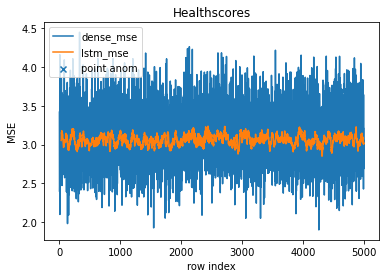

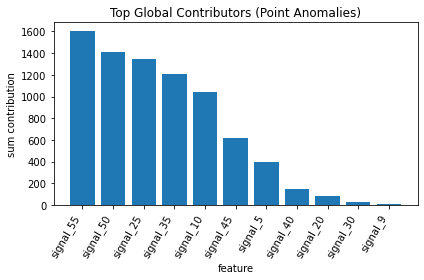

[foreachBatch] batch_id=1 ERROR: name 'metrics_path' is not defined
Traceback (most recent call last):
  File "C:\Users\ISHAAN~1\AppData\Local\Temp/ipykernel_3260/2336560260.py", line 211, in score_and_detect
    spark.createDataFrame(metrics_pdf).write.mode("append").parquet(metrics_path)
NameError: name 'metrics_path' is not defined

[foreachBatch] batch_id=2 received
[foreachBatch] batch_id=2 rows=4800
[foreachBatch] batch_id=2 limited to 2000 rows
[foreachBatch] batch_id=2 ERROR: name 'metrics_path' is not defined
Traceback (most recent call last):
  File "C:\Users\ISHAAN~1\AppData\Local\Temp/ipykernel_3260/2336560260.py", line 211, in score_and_detect
    spark.createDataFrame(metrics_pdf).write.mode("append").parquet(metrics_path)
NameError: name 'metrics_path' is not defined

[foreachBatch] batch_id=3 received
[foreachBatch] batch_id=3 rows=2600
[foreachBatch] batch_id=3 limited to 2000 rows
[foreachBatch] batch_id=3 ERROR: name 'metrics_path' is not defined
Traceback (most rece

In [34]:
load_scores(1000)
plot_healthscores(5000)
plot_global_contributors(15)